In [13]:
import pandas as pd
import numpy as np
df = pd.read_csv('../../data/cleanData/oneEncodedDiscord.csv')
df.head()

,Unnamed: 0,major_department,year,music_genre,living,humour,friend_qualities,personal_qualities,sports,friday_night,school_balance,entertainment_genre
0,0,1,4,9,0,3,"Trustworthy, Social Intelligence, Humour","Understanding, Supportive, Loyalty",1,2,0,2
1,1,2,4,6,0,0,"Trustworthy, Kindness, Loyalty","Trustworthy, Kindness, Loyalty",0,0,0,1
2,2,1,4,6,0,3,"Ambition, Kindness, Understanding","Ambition, Kindness, Leadership",0,1,1,7
3,3,1,4,3,0,1,"Kindness, Understanding, Supportive","Kindness, Understanding, Social Intelligence",0,2,1,5
4,4,1,4,1,0,1,"Trustworthy, Understanding, Humour","Ambition, Supportive, Loyalty",1,3,1,1


In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

In [14]:
#scaling: helps with the clustering performance
#purpose of scaling = brings all features in the same standing, crucial in preprocessing
#https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35
#by scaling you are making sure that certain significant numbers are not playing a decisive role while training 
#initialize the scaler:
scaler = MinMaxScaler() #scales each feature in a give range 0, 1
df = df[['friend_qualities', 
'personal_qualities']].join(
              pd.DataFrame(
          scaler.fit_transform(
                               df.drop(columns =['friend_qualities', 'personal_qualities'],axis = 1)),  
                               index=df.index))
df.head()

,friend_qualities,personal_qualities,0,1,2,3,4,5,6,7,8,9
0,"Trustworthy, Social Intelligence, Humour","Understanding, Supportive, Loyalty",0.000000,0.5,1.0,0.818182,0.0,0.75,1.0,0.666667,0.0,0.250
1,"Trustworthy, Kindness, Loyalty","Trustworthy, Kindness, Loyalty",0.027027,1.0,1.0,0.545455,0.0,0.00,0.0,0.000000,0.0,0.125
2,"Ambition, Kindness, Understanding","Ambition, Kindness, Leadership",0.054054,0.5,1.0,0.545455,0.0,0.75,0.0,0.333333,0.5,0.875
3,"Kindness, Understanding, Supportive","Kindness, Understanding, Social Intelligence",0.081081,0.5,1.0,0.272727,0.0,0.25,0.0,0.666667,0.5,0.625
4,"Trustworthy, Understanding, Humour","Ambition, Supportive, Loyalty",0.108108,0.5,1.0,0.090909,0.0,0.25,1.0,1.000000,0.5,0.125


In [11]:
#initiating the vectorizer
#Count vectorizer: converts a collection of text documents to a vector of term/token counts
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df[['personal_qualities', 'friend_qualities']])

# Creating a new DF that contains the vectorized words
df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())

# Concating the words DF with the original DF
new_df = pd.concat([df, df_wrds], axis=1)

# Dropping the Bios because it is no longer needed in place of vectorization
new_df.drop(['personal_qualities', 'friend_qualities'], axis=1, inplace=True)

new_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.5,1.0,0.818182,0.0,0.75,1.0,0.666667,0.0,0.250
1,0.027027,1.0,1.0,0.545455,0.0,0.00,0.0,0.000000,0.0,0.125
2,0.054054,0.5,1.0,0.545455,0.0,0.75,0.0,0.333333,0.5,0.875
3,0.081081,0.5,1.0,0.272727,0.0,0.25,0.0,0.666667,0.5,0.625
4,0.108108,0.5,1.0,0.090909,0.0,0.25,1.0,1.000000,0.5,0.125


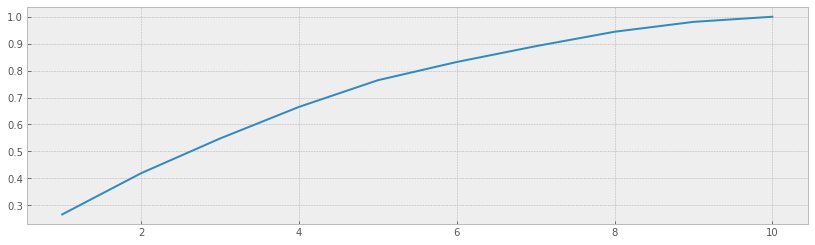

Number features: 8
Total Variance Explained: 0.9809752271271448
0.9442828724843971


In [15]:
# Importing the library
from sklearn.decomposition import PCA

# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(new_df)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,new_df.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features that explain at least 95% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = new_df.shape[1] - n_over_95

# Printing out the number of features needed to retain 95% variance
print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_95)

# Fitting and transforming the dataset to the stated number of features and creating a new DF
df_pca = pca.fit_transform(new_df)

# Seeing the variance ratio that still remains after the dataset has been reduced
print(pca.explained_variance_ratio_.cumsum()[-1])

In [9]:
cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:
    
    # Hierarchical Agglomerative Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)
    
    hac.fit(df_pca)
    
    cluster_assignments = hac.labels_
    
    ## KMeans Clustering with different number of clusters
    #k_means = KMeans(n_clusters=i)
    
    #k_means.fit(df_pca)
    
    #cluster_assignments = k_means.predict(df_pca)
    
    # Appending the scores to the empty lists    
    s_scores.append(silhouette_score(df_pca, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(df_pca, cluster_assignments))


Max Value:
Cluster #    Cluster Score
2       0.252284

Min Value:
Cluster #    Cluster Score
5       0.172808


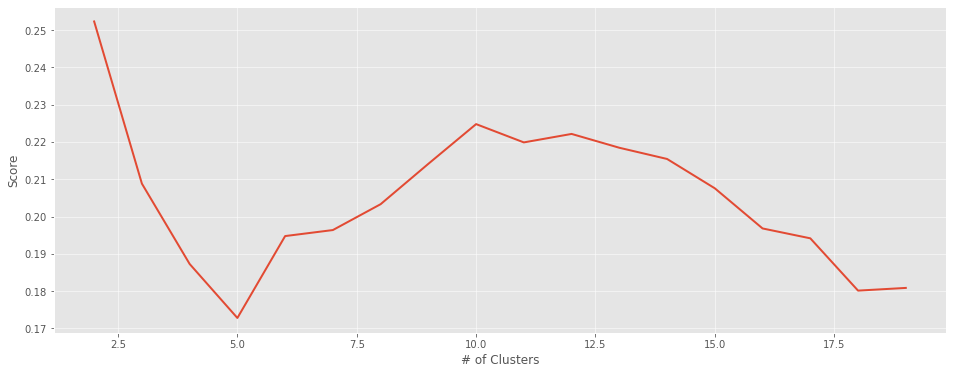

Max Value:
Cluster #    Cluster Score
5       1.771879

Min Value:
Cluster #     Cluster Score
19       0.784219


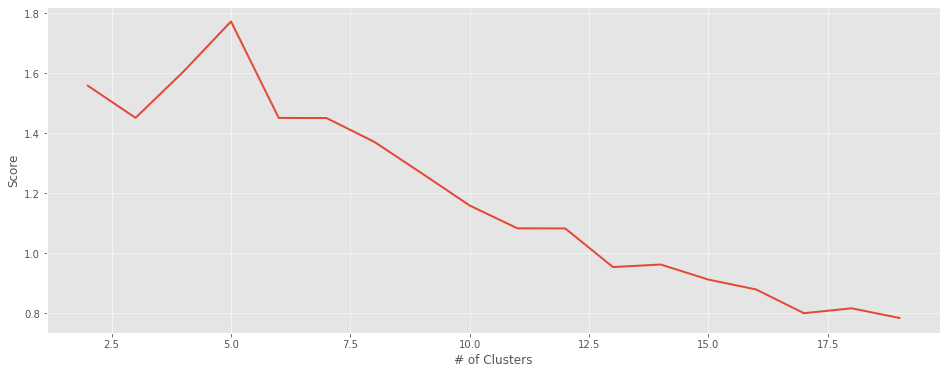

In [16]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()
    
# Running the function on the list of scores
plot_evaluation(s_scores)

plot_evaluation(db_scores)

In [21]:
# Instantiating HAC
hac = AgglomerativeClustering(n_clusters=5)

# Fitting
hac.fit(df_pca)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Unscaling the categories then replacing the scaled values
df = df[['personal_qualities','friend_qualities']].join(pd.DataFrame(scaler.inverse_transform(df.drop(columns =['personal_qualities', 'friend_qualities'], axis=1)), index=df.index))

# Assigning the clusters to each profile
df['Cluster #'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
df

,personal_qualities,friend_qualities,0,1,2,3,4,5,6,7,8,9,Cluster #
0,"Understanding, Supportive, Loyalty","Trustworthy, Social Intelligence, Humour",0.0,1.0,4.0,9.0,0.0,3.0,1.0,2.0,0.0,2.0,1
1,"Trustworthy, Kindness, Loyalty","Trustworthy, Kindness, Loyalty",1.0,2.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,3
2,"Ambition, Kindness, Leadership","Ambition, Kindness, Understanding",2.0,1.0,4.0,6.0,0.0,3.0,0.0,1.0,1.0,7.0,4
3,"Kindness, Understanding, Social Intelligence","Kindness, Understanding, Supportive",3.0,1.0,4.0,3.0,0.0,1.0,0.0,2.0,1.0,5.0,4
4,"Ambition, Supportive, Loyalty","Trustworthy, Understanding, Humour",4.0,1.0,4.0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,1
5,"Ambition, Humour, Loyalty","Ambition, Trustworthy, Humour",5.0,1.0,3.0,1.0,0.0,1.0,0.0,2.0,1.0,3.0,4
6,"Ambition, Fairness, Supportive","Ambition, Trustworthy, Supportive",6.0,2.0,4.0,1.0,0.0,2.0,1.0,2.0,0.0,5.0,1
7,"Ambition, Leadership, Social Intelligence","Kindness, Supportive, Humour",7.0,1.0,3.0,6.0,0.0,3.0,1.0,0.0,1.0,8.0,0
8,"Kindness, Understanding, Supportive","Kindness, Supportive, Humour",8.0,2.0,4.0,4.0,0.0,3.0,0.0,2.0,0.0,1.0,4
9,"Ambition, Fairness, Humour","Trustworthy, Humour, Loyalty",9.0,0.0,4.0,4.0,0.0,1.0,1.0,0.0,0.0,2.0,1
